In [ ]:
import pandas as pd
import os
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image  import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
path = ("/content/gdrive/MyDrive/Data_Source/Dataset/casting_data/casting_data/")

In [ ]:
path = ("/content/gdrive/MyDrive/Data_Source/Dataset/casting_data/casting_data/")
train_df = path + "train/def_front/"
train_ok = path + "train/ok_front/"

test_def = path + 'test/def_front/'
test_ok = path + 'test/ok_front/'

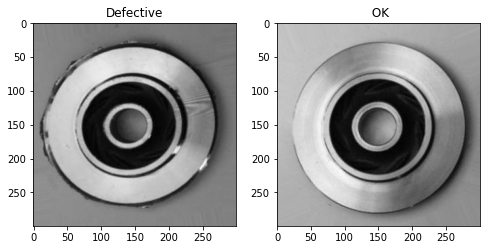

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (8,4))

axes[0].imshow(plt.imread(train_df + os.listdir(train_df)[0]))
axes[1].imshow(plt.imread(train_ok+os.listdir(train_ok)[0]))
axes[0].set_title('Defective')
axes[1].set_title(' OK')
plt.show()



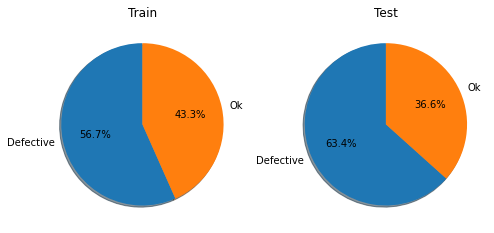

 Defective Training Images 	: 3758
 Ok Training Images 		: 2875

 Defective Testing Images 	: 453
 Ok Testing Images 		: 262


In [ ]:
x_train = np.array([len(os.listdir(train_df)),len(os.listdir(train_ok))])
x_test = np.array([len(os.listdir(test_def)),len(os.listdir(test_ok))])
label = ['Defective','Ok']
  
fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].pie(x_train, labels=label, autopct='%1.1f%%',shadow=True, startangle=90)
axes[1].pie(x_test, labels=label, autopct='%1.1f%%',shadow=True, startangle=90)
axes[0].set_title('Train')
axes[1].set_title('Test')
plt.show()

print(' Defective Training Images \t: ' + str(len(os.listdir(train_df))))
print(' Ok Training Images \t\t: ' + str(len(os.listdir(train_ok))))
print()
print(' Defective Testing Images \t: ' + str(len(os.listdir(test_def))))
print(' Ok Testing Images \t\t: ' + str(len(os.listdir(test_ok))))

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [ ]:

fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].box(x_train, labels=label, autopct='%1.1f%%',shadow=True, startangle=90)
axes[1].box(x_test, labels=label, autopct='%1.1f%%',shadow=True, startangle=90)
axes[0].set_title('Train')
axes[1].set_title('Test')

Data loading and perprocessing¶
- 0/1 Normalization 
- Grayscale
- input shape resize for CNN (300x300)

In [ ]:
# Using IDG to load images from directory
train_idg = ImageDataGenerator(rescale=1./255, validation_split=0.3) # 30 percent validation split for training 
test_idg = ImageDataGenerator(rescale=1./255)

# Specify parameters/arguments for data generation
img_size = (300, 300)
batch_size = 64

arg_train = {'target_size': img_size,
             'color_mode': 'grayscale',
             'class_mode': 'binary',
             'batch_size': batch_size}
arg_test = {'target_size': img_size,
            'color_mode': 'grayscale',
            'class_mode': 'binary',
            'batch_size': batch_size,
            'shuffle': False}

train = train_idg.flow_from_directory(directory=path+'train/', subset='training', **arg_train)

# Generator para parte validação
validation_generator = train_idg.flow_from_directory(directory=path+'train/', subset='validation', **arg_train)
# Generator para dataset de teste
test  = test_idg.flow_from_directory(directory=path+'test/', **arg_test)

nb_train_samples = train.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test.samples
classes = list(train.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)

Found 4644 images belonging to 2 classes.
Found 1989 images belonging to 2 classes.
Found 715 images belonging to 2 classes.
Classes: ['def_front', 'ok_front']


In [ ]:
train.class_indices

{'def_front': 0, 'ok_front': 1}

In [ ]:
# Visualizando alguns exemplos do dataset por meio do Generator criado
plt.figure(figsize=(15,15))
for i in range(9):
    #gera subfigures
    plt.subplot(330 + 1 + i)
    batch = train.next()[0]*255
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()

In [ ]:
img_size + (1,)

(300, 300, 1)

In [ ]:
#X_train = X_train.reshape((X_train.shape[0],28,28,1)).astype('float32')/255


In [ ]:
cnn = Sequential([ 
    Conv2D(32, 3, activation='relu', padding='same', strides=2,input_shape=img_size+(1,)),
    MaxPooling2D(pool_size=2, strides=2),
    Conv2D(64, 3, activation='relu', padding='same', strides=2),
    MaxPooling2D(pool_size=2, strides=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  
])

#compila o  modelo
cnn.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

cnn.summary()
#plot_model(cnn, show_shapes=True, expand_nested=True, dpi=60)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 38, 38, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 19, 19, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 23104)             0         
                                                                 
 dense_4 (Dense)             (None, 128)               2

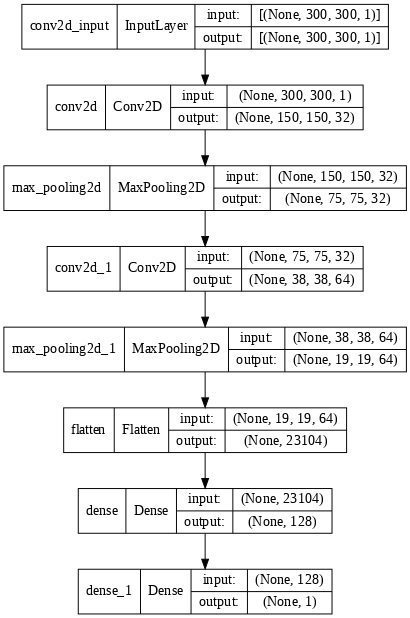

In [ ]:
plot_model(cnn, 'MNIST model.png', show_shapes=True, expand_nested=True, dpi=70)

In [ ]:
# Training model
batch_size = 32
epochs = 10

#Save model 
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='/content/gdrive/MyDrive/MachineLearning/model_predict.h5',
        monitor='val_loss', save_best_only=False, verbose=1), #mode = 'auto'
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,verbose=1)
]

history = cnn.fit(train,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks = callbacks_list,
                    verbose=1,
                    validation_data=test
                 )



Epoch 1/10
73/73 [==============================] - ETA: 0s - loss: 0.6264 - accuracy: 0.6288
Epoch 00001: saving model to /content/gdrive/MyDrive/MachineLearning/model_predict.h5
73/73 [==============================] - 392s 5s/step - loss: 0.6264 - accuracy: 0.6288 - val_loss: 0.6994 - val_accuracy: 0.5972
Epoch 2/10
73/73 [==============================] - ETA: 0s - loss: 0.4790 - accuracy: 0.7672
Epoch 00002: saving model to /content/gdrive/MyDrive/MachineLearning/model_predict.h5
73/73 [==============================] - 24s 330ms/step - loss: 0.4790 - accuracy: 0.7672 - val_loss: 0.3838 - val_accuracy: 0.8378
Epoch 3/10
73/73 [==============================] - ETA: 0s - loss: 0.3305 - accuracy: 0.8568
Epoch 00003: saving model to /content/gdrive/MyDrive/MachineLearning/model_predict.h5
73/73 [==============================] - 24s 324ms/step - loss: 0.3305 - accuracy: 0.8568 - val_loss: 0.2477 - val_accuracy: 0.9259
Epoch 4/10
73/73 [==============================] - ETA: 0s - loss

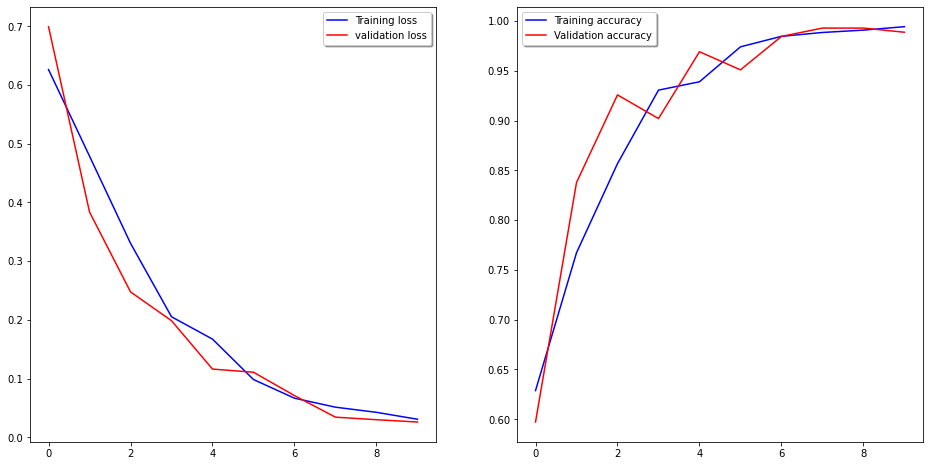

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
# Test
score = cnn.evaluate(train,verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
y_pred = cnn.predict(test)
y_pred = (y_pred >= 0.5).reshape(-1,)

In [ ]:
y_actual = test.classes[test.index_array]

In [ ]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_actual, y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_actual, y_pred, digits=4))

NameError: ignored

Transfer Learning from a Deep Model


In [ ]:
data_generator = ImageDataGenerator(
        validation_split=0.2,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        preprocessing_function=preprocess_input,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
val_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.2)




In [ ]:
seed = 10
# Generator para parte train
train_generator = data_generator.flow_from_directory(path, target_size=img_size, shuffle=True, seed=seed,
                                                     class_mode='categorical', batch_size=batch_size, subset="training")
# Generator para parte validação
validation_generator = val_data_generator.flow_from_directory(path, target_size=img_size, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=batch_size, subset="validation")

# Generator para dataset de teste
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_generator.flow_from_directory(path, target_size=img_size, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=batch_size)

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)

Found 5879 images belonging to 2 classes.
Found 1469 images belonging to 2 classes.
Found 7348 images belonging to 2 classes.
Classes: ['test', 'train']


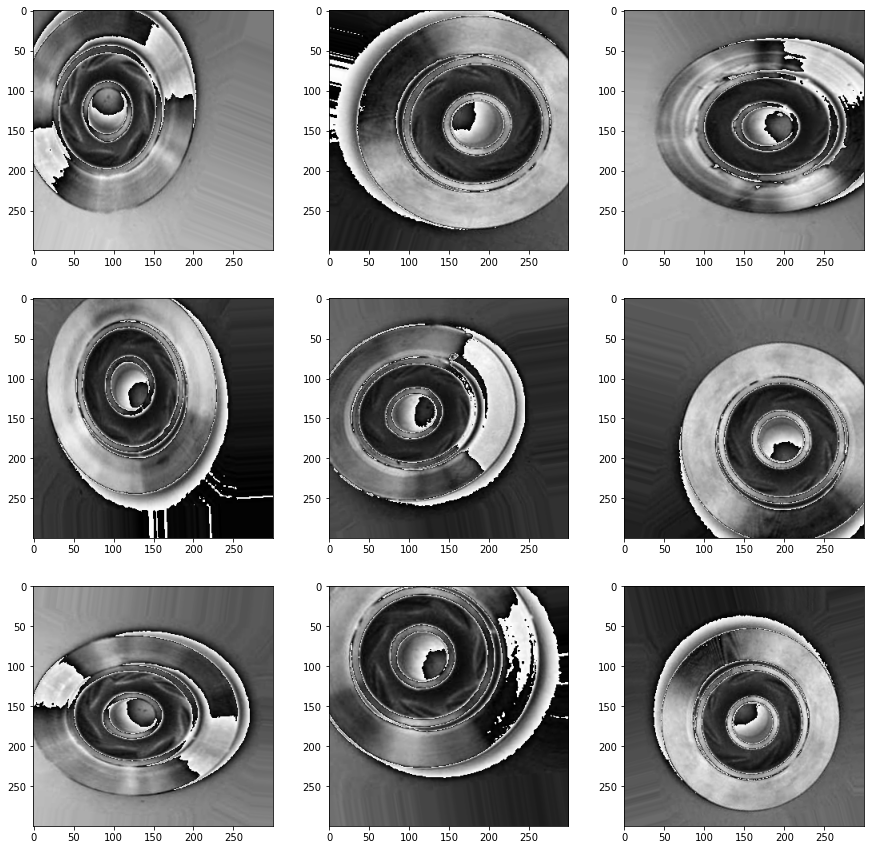

In [ ]:
plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = train_generator.next()[0]*255
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()

In [ ]:
from keras.applications.vgg16 import VGG16

base_model = VGG16(include_top=False, input_shape=(300, 300, 3))

x = base_model.output
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax', kernel_initializer='random_uniform')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freezing pretrained layers
for layer in base_model.layers:
    layer.trainable=False
    
optimizer = Adam()
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
base_model

In [ ]:
epochs = 30

# Saving the best model
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='/content/gdrive/MyDrive/MachineLearning/model.h5',
        monitor='val_loss', verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,verbose=1)
]


history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=validation_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // batch_size)

In [ ]:
batch = train_generator.next()[0]*255
print(batch)